In [67]:
from brian2 import *
from DynapSE import DynapSE
from Spike_G import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings/dynapse-simulator-New-Parameters/

BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

In [68]:

def SFA(ampa_conf,adaptation_conf,freq_list):    
    device.reinit()
    device.activate()
    defaultclock.dt = 20 * us

    ## Observing Adaptation Effect
    ##################
    inp_duration=1

    # Create a Brian2 network and chip instance and neurons-
    network = Network()
    chip = DynapSE(network)
    DPI_neurons  = chip.get_neurons(len(freq_list), 'Core_1')

    DPI_synapses=[]
    Spike_Generators=[]
    counter1=0
    counter2=1

    # Connect a single spike generator to a single DPI neuron 
    for i in range(len(freq_list)):
        #SpikeGen(input_type,start,end,duration,freq,numberofinstances,name)
        Spike_Generators.append(SpikeGen('regular',0,1,1,freq_list[i],1,'SpikeGenerator'+str(i)))
        DPI_synapses.append(chip.add_connection(Spike_Generators[i],DPI_neurons[counter1:counter2], synapse_type='AMPA'))
        chip.connect(DPI_synapses[i], True)
        DPI_synapses[i].weight = 1
        
        counter1=counter1+1
        counter2=counter2+1
        


    # merge the param dict into 1.
    core_conf = {**ampa_conf,**adaptation_conf}
    # set the params
    chip.set_bias(core_conf, 'Core_1')

    # Monitors
    mon_neuron_output_1 = SpikeMonitor(DPI_neurons[0:1], name='mon_neuron_output_1',record=True)
    mon_neuron_output_2 = SpikeMonitor(DPI_neurons[1:2], name='mon_neuron_output_2',record=True)
    mon_neuron_output_3 = SpikeMonitor(DPI_neurons[2:3], name='mon_neuron_output_3',record=True)
    mon_neuron_output_4 = SpikeMonitor(DPI_neurons[3:4], name='mon_neuron_output_4',record=True)
    mon_synapse_ampa  = StateMonitor(DPI_synapses[0], 'I_syn_ampa', record=[0])
    mon_synapse_ampa  = StateMonitor(DPI_synapses[1], 'I_syn_ampa', record=[0])
    mon_synapse_ampa  = StateMonitor(DPI_synapses[2], 'I_syn_ampa', record=[0])
    mon_synapse_ampa  = StateMonitor(DPI_synapses[3], 'I_syn_ampa', record=[0])
    mon_adapt_state  = StateMonitor(DPI_neurons,  'Iahp', record=True)
    mon_mem_state = StateMonitor(DPI_neurons,  'Imem', record=True)
    network.add([Spike_Generators, DPI_neurons, DPI_synapses,mon_synapse_ampa,mon_adapt_state,mon_mem_state])
    network.add([mon_neuron_output_1,mon_neuron_output_2,mon_neuron_output_3,mon_neuron_output_4])
    # Simulation
    network.run(inp_duration * 1000 * ms)
  

    
    fig1, (ax) = plt.subplots(1, 1,figsize=(12,4),dpi=150)
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[0].Iahp/pA,label='ISI 200 Hz')
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[1].Iahp/pA,label='ISI 300 Hz')
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[2].Iahp/pA,label='ISI 500 Hz')
    ax.plot(mon_adapt_state.t/ms,mon_adapt_state[3].Iahp/pA,label='ISI 1000 Hz')
    ax.set_title('SFA')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Current (PA)')
    ax.legend()

    # plotting
    plt.figure(figsize=(12,4),dpi=150)
    plt.subplots_adjust(hspace=2)
    plt.subplot(4,1,1)

    plot(mon_mem_state.t/ms,mon_mem_state[0].Imem/pA ,linewidth=1.5,label='$I_{mem}$ 200 Hz')
    plt.title('$I_{mem}$ 200 Hz')
    plt.ylabel('Current (pA)')
    #plt.legend(loc='upper right')

    plt.subplot(4,1,2)

    plot(mon_adapt_state.t/ms,mon_mem_state[1].Imem/pA, linewidth=1.5,label='$I_{mem}$ 300 Hz')
    plt.title('$I_{mem}$ 300 Hz')
    plt.ylabel('Current (p)')
    #plt.legend(loc='upper right')

    plt.subplot(4,1,3)
    plot(mon_adapt_state.t/ms,mon_mem_state[2].Imem/pA, linewidth=1.5,label='$I_{mem}$ 500 Hz')
    plt.title('$I_{mem}$ 500 Hz')
    plt.ylabel('Current (pA)')
    #plt.legend(loc='upper right')

    plt.subplot(4,1,4)
    plot(mon_adapt_state.t/ms,mon_mem_state[3].Imem/pA, linewidth=1.5,label='$I_{mem}$ 1000 Hz')
    plt.title('$I_{mem}$ 1000 Hz')
    plt.ylabel('Current (pA)')
    #plt.legend(loc='upper right')
    plt.xlabel('Time (ms)')

    fig2, (ax1,ax2) = plt.subplots(1, 2,figsize=(24,6))
    ax1.plot(np.diff(mon_neuron_output_1.t/ms),'o',label='ISI 200 Hz')
    ax1.plot(np.diff(mon_neuron_output_2.t/ms),'o',label='ISI 300 Hz')
    ax1.plot(np.diff(mon_neuron_output_3.t/ms),'o',label='ISI 500 Hz')
    ax1.plot(np.diff(mon_neuron_output_4.t/ms),'o',label='ISI 1000 Hz')
    ax1.set_title('SFA')
    ax1.set_xlabel('Spike number')
    ax1.set_ylabel('Output ISI (ms)')
    ax1.legend()
    ax1.grid()

    ax2.plot(remove_last_element(np.array(mon_neuron_output_1.t/ms)),1/(np.diff(mon_neuron_output_1.t)),label='freq 1')
    ax2.plot(remove_last_element(np.array(mon_neuron_output_2.t/ms)),1/(np.diff(mon_neuron_output_2.t)),label='freq 2')
    ax2.plot(remove_last_element(np.array(mon_neuron_output_3.t/ms)),1/(np.diff(mon_neuron_output_3.t)),label='freq 3')
    ax2.plot(remove_last_element(np.array(mon_neuron_output_4.t/ms)),1/(np.diff(mon_neuron_output_4.t)),label='freq 4')
    ax2.set_title('Frequency vs Spike number')
    ax2.set_xlabel('Spike number')
    ax2.set_ylabel('Frequency(hz)')
    ax2.legend()

    print('Output firing rate 1 = ', mon_neuron_output_1.count/ (inp_duration* 1000 * ms))
    print('Output firing rate 2 = ', mon_neuron_output_2.count/ (inp_duration* 1000 * ms))
    print('Output firing rate 3 = ', mon_neuron_output_3.count/ (inp_duration* 1000 * ms))
    print('Output firing rate 4 = ', mon_neuron_output_4.count/ (inp_duration* 1000 * ms))

    print(DPI_neurons[0:1].tau.get_item(0))
    print(DPI_neurons[1:2].tau.get_item(0))
    print(DPI_neurons[2:3].tau.get_item(0))
    print(DPI_neurons[3:4].tau.get_item(0))
    plt.grid(True)

    return mon_adapt_state,mon_mem_state,mon_neuron_output_1,mon_neuron_output_2,mon_neuron_output_3,mon_neuron_output_4,DPI_neurons

    


In [69]:
def remove_last_element(arr):
    return arr[np.arange(arr.size - 1)]

4 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
Output firing rate 1 =  [0.] Hz
Output firing rate 2 =  [0.] Hz
Output firing rate 3 =  [52.] Hz
Output firing rate 4 =  [98.] Hz
26.59574468 ms
26.59574468 ms
26.59574468 ms
26.59574468 ms


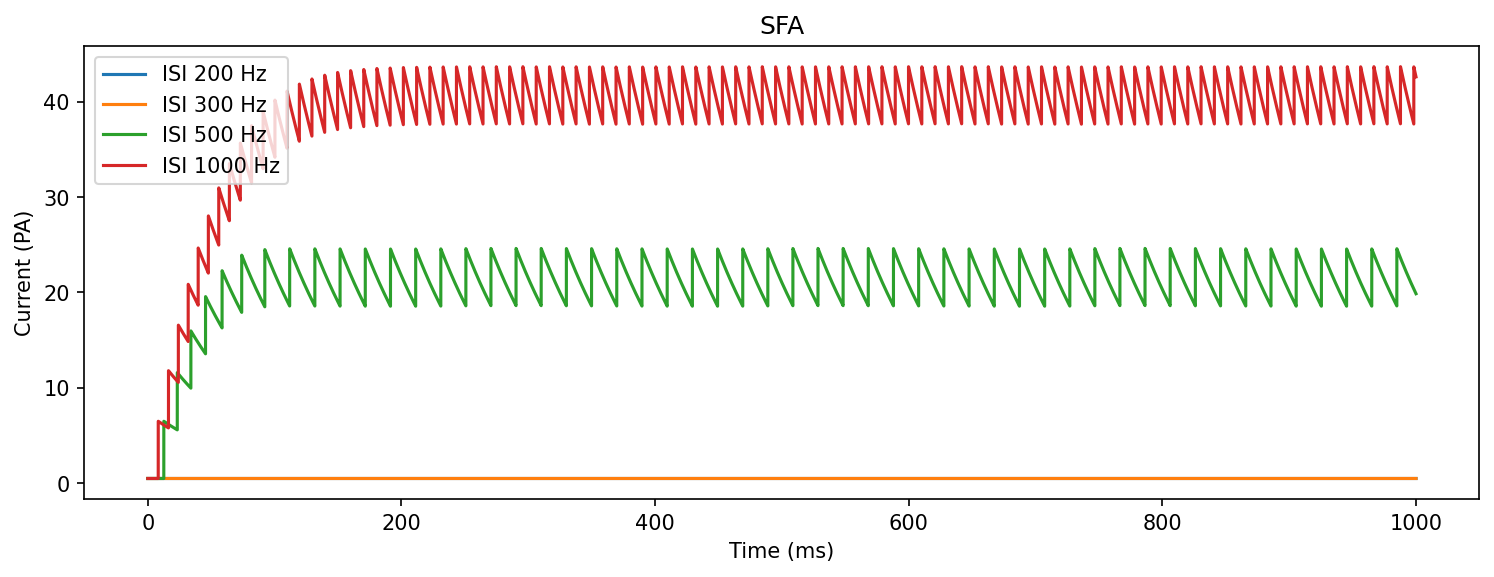

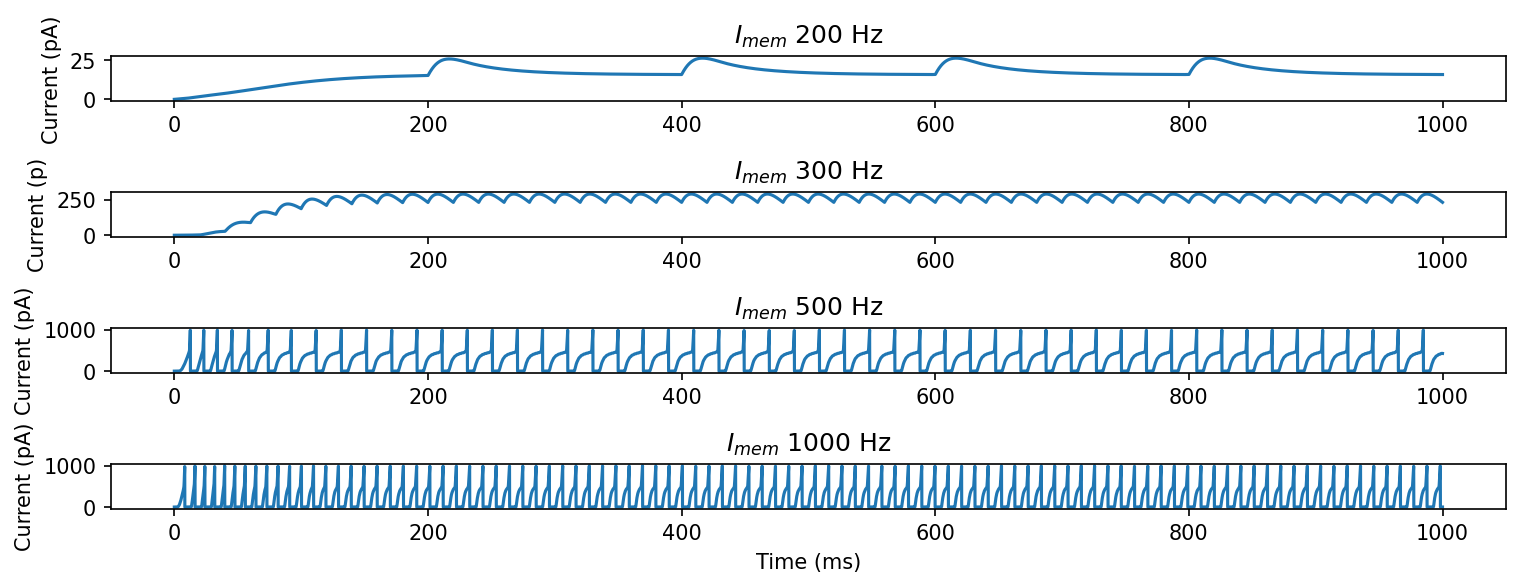

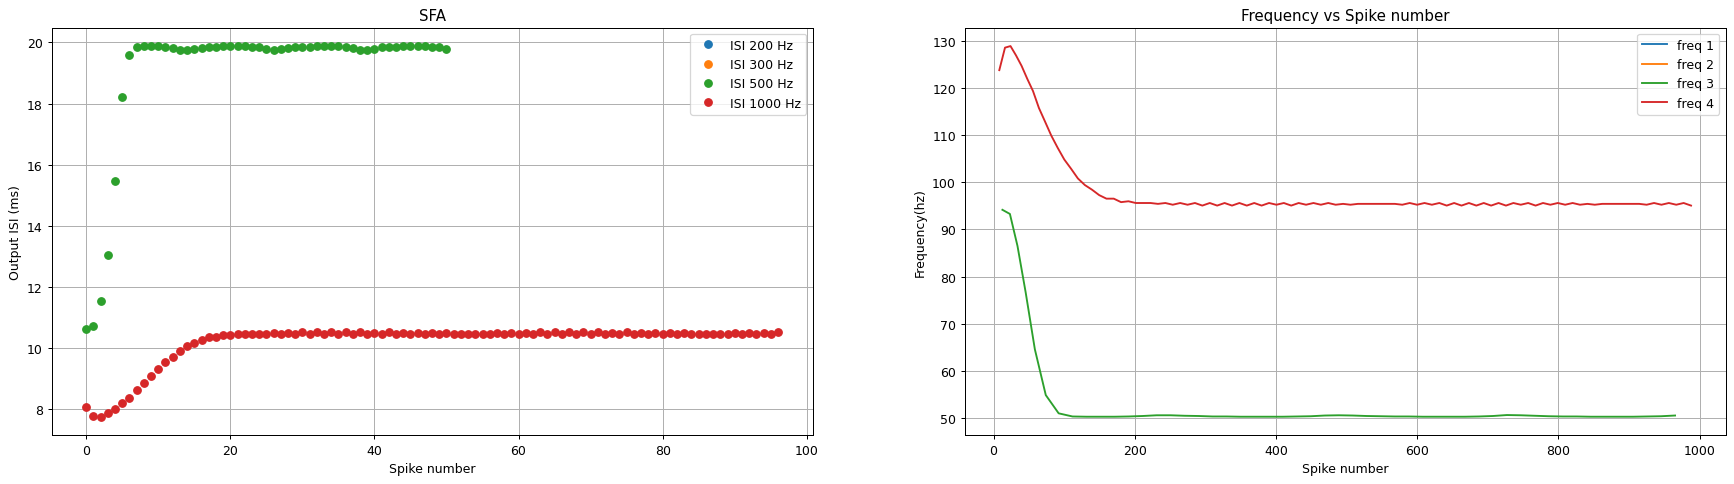

In [70]:
import math

import matplotlib.pyplot as plt
from matplotlib import gridspec

freq_list=[5,50,500,1000]*Hz


adaptation_conf = {
                   "Itau" : 2 * pA,
                   "Ith"  : 20 * pA,                   
                   "Itauahp": 0.5 * pA,                 
                   "Ithahp": .5 * pA,
                   "Ica" : 6 * pA,
                   "refP": 5. * ms,
                   "Iconst": 5 *pA
                  }

ampa_conf = {"I_tau_syn_ampa": 5 * pA,
            "I_g_syn_ampa":  5 * pA,
            "I_wo_syn_ampa": 100 * pA}




[mon_adapt_state,mon_mem_state,o1,o2,o3,o4,DPI_neurons]=SFA(ampa_conf,adaptation_conf,freq_list)




# Plotting output ISI


In [71]:

# Add code here
# to start a new build to run multiple full simulations
tau_list=[10,20,30,40,50]*pA
freq_list=[10,50,100,200,300,500]*Hz
firing_rate=[]
N=10
for tau in tau_list:
    device.reinit()
    device.activate()
    # need to reset the defaultclock after activate
    defaultclock.dt = 20 * us
    
    network = Network()
    chip = DynapSE(network)
    seed(4321)
    # Create a poisson spike generator with 100 Hz
    # Allocate single neuron from Core 1
    DPI_neurons  = chip.get_neurons(len(freq_list), 'Core_1')
    DPI_neurons.Iconst = 0 * pA 
    # Define an AMPA synapse to connect the spike generator to the neuron 
    
    # In Brian2 creating a Synapses instance does not create synapses, it only specifies their dynamics.
    # so remember to call connect function to really build the connection
    Spike_Generators=[]
    DPI_synapses=[]
    counter1=0
    counter2=1
    for i in range(len(freq_list)):
        
        Spike_Generators.append(PoissonGroup(1, freq_list[i]))
        DPI_synapses.append(chip.add_connection(Spike_Generators[i],DPI_neurons[counter1:counter2], synapse_type='AMPA'))
        chip.connect(DPI_synapses[i], True)
        DPI_synapses[i].weight = 100 # number of synapse and not weight
        counter1=counter1+1
        counter2=counter2+1
        
        
        
        

    # here we set an initial weight of 200.
    

    ampa_conf_2 = {'Itau': tau}

    #increase I_tau

    chip.set_bias(ampa_conf_2,'Core_1')

    chip.set_bias(adaptation_conf,'Core_1')
    chip.set_bias(ampa_conf,'Core_1')

    # monitors
    mon_synapse_state = StateMonitor(DPI_synapses[0], 'I_syn_ampa', record=[0]) # it's not I_syn_exc2
    mon_neuron_state  = StateMonitor(DPI_neurons,  'Imem', record=[0])
    mon_neuron_input  = SpikeMonitor(Spike_Generators[0], name='mon_neuron_input')
    mon_neuron_output = SpikeMonitor(DPI_neurons, name='mon_neuron_output')

    # add all the instances into the network 
    network.add([Spike_Generators, DPI_neurons, DPI_synapses, 
                 mon_synapse_state, mon_neuron_state, mon_neuron_input, mon_neuron_output])

    # Simulation
    duration = .5 * second
    network.run(duration)
    print('Output firing rate = ', mon_neuron_output.count/ (duration))
    firing_rate.append(mon_neuron_output.count/ (duration))

6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [ 22. 124. 176. 190. 194. 196.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [ 22. 124. 176. 190. 194. 196.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [ 22. 124. 176. 190. 194. 196.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rate =  [ 22. 124. 176. 190. 194. 196.] Hz
6 neurons are allocated from Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
New bias values are loaded to Core_1.
Output firing rat

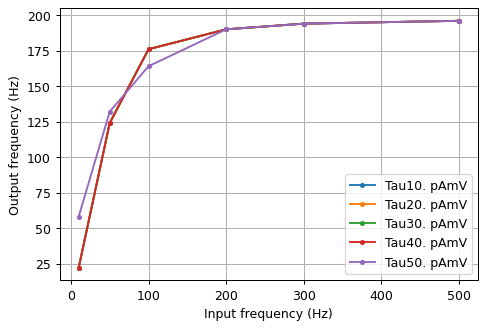

In [72]:
array_fr=np.array(firing_rate)
for i in range(len(firing_rate)):
    plot(freq_list, array_fr[i], ".-",label='Tau'+str(tau_list[i])+'mV')
    grid()
    

xlabel('Input frequency (Hz)')
ylabel('Output frequency (Hz)')
legend(loc='best')
show()
